In [11]:
import itertools
import json
from pprint import pprint
from typing import List

import clip  # type: ignore
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import spearmanr, pearsonr

from datasets import AttributeDataset, ImageDataset, TextDataset, create_dataloader
from models import Linear
from trainer import run_one_epoch
from utils import computing_subgroup_metrics, subgrouping
from matplotlib import pyplot as plt
from utils import openai_imagenet_template, openai_imagenet_classes
from collections import defaultdict


CLIP_MODEL = "ViT-B/32"
# LINEAR_MODEL = "pytorch_cache/models/waterbird_linear_model.pt"
LINEAR_MODEL = "waterbird_linear_model_gap=False.pt"
N_CLASS = 2
clip_model, transform = clip.load(name=CLIP_MODEL, device="cuda")
clip_model = clip_model.float()
model = Linear(clip_model.visual.output_dim, N_CLASS).cuda()
state_dict = torch.load(LINEAR_MODEL)
model.load_state_dict(state_dict)

<All keys matched successfully>

# Slice Analysis

## [Preparation] Ground-truth image dataset and text cross-product performance

In [12]:
image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/Waterbird/processed_attribute_dataset/attributes.jsonl"
    )
]


def filter_fn(x):
    return x["attributes"]["split"] == "val"


image_data = [x for x in image_data if filter_fn(x)]


def label_fn(x):
    return x["attributes"]["waterbird"]


for item in image_data:
    item["label"] = label_fn(item)

image_dataset = ImageDataset(data=image_data)
image_dataloader = create_dataloader(
    dataset=image_dataset, modality="image", transform=transform
)
image_metrics = run_one_epoch(
    dataloader=image_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

# Dataset attributes
attributes = {
    "place": set([x["attributes"]["place"] for x in image_data]),
    "species": set([x["attributes"]["species"] for x in image_data]),
}
attributes_combinations = [
    dict(zip(attributes, x)) for x in itertools.product(*attributes.values())
]
species_to_label = {
    x["attributes"]["species"]: x["attributes"]["waterbird"] for x in image_data
}
places_to_label = {
    x["attributes"]["place"]: x["attributes"]["waterplace"] for x in image_data
}

################################ Raw ################################
# text_data = [
#     {
#         "text": f"{x['species']}, {x['place']}.",
#         "label": species_to_label[x["species"]],
#         "attributes": {
#             "waterbird": species_to_label[x["species"]],
#             "waterplace": places_to_label[x["place"]],
#             "species": x["species"],
#             "place": x["place"],
#         },
#     }
#     for x in attributes_combinations
# ]

################################ Prompt Engineering ################################
# text_data = [
#     {
#         "text": f"a photo of a {x['species']} in the {x['place']}.",
#         "label": species_to_label[x["species"]],
#         "attributes": {
#             "waterbird": species_to_label[x["species"]],
#             "waterplace": places_to_label[x["place"]],
#             "species": x["species"],
#             "place": x["place"],
#         },
#     }
#     for x in attributes_combinations
# ]

################################ Prompt Ensemble ################################
text_data = [
    {
        "text": prompt(f"{x['species']} in the {x['place']}"),
        "label": species_to_label[x["species"]],
        "attributes": {
            "waterbird": species_to_label[x["species"]],
            "waterplace": places_to_label[x["place"]],
            "species": x["species"],
            "place": x["place"],
        },
    }
    for x in attributes_combinations
    for prompt in openai_imagenet_template
]

# TODO: select one from above

text_dataset = TextDataset(data=text_data)
text_dataloader = create_dataloader(dataset=text_dataset, modality="text")
text_metrics = run_one_epoch(
    dataloader=text_dataloader,
    model=model,
    clip_model=clip_model,
    modality="text",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

Epoch -1, Eval True: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.49it/s]


## Larger slice discovery

In [4]:
fields = ["waterbird", "waterplace"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1]))
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1]))
print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (
        ("waterbird", x["attributes"]["waterbird"]),
        ("waterplace", x["attributes"]["waterplace"]),
    )
    value = text_probs[i][x["label"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1]))
print()

[((('waterbird', 1), ('waterplace', 0)), 0.3233082706766917),
 ((('waterbird', 0), ('waterplace', 1)), 0.6523605150214592),
 ((('waterbird', 1), ('waterplace', 1)), 0.9548872180451128),
 ((('waterbird', 0), ('waterplace', 0)), 0.9978586723768736)]

[((('waterbird', 1), ('waterplace', 0)), 0.2403532608695652),
 ((('waterbird', 0), ('waterplace', 1)), 0.7508116883116883),
 ((('waterbird', 1), ('waterplace', 1)), 0.9490489130434783),
 ((('waterbird', 0), ('waterplace', 0)), 1.0)]

[((('waterbird', 1), ('waterplace', 0)), 0.3258371420962011),
 ((('waterbird', 0), ('waterplace', 1)), 0.7029175708865462),
 ((('waterbird', 1), ('waterplace', 1)), 0.9306395012892924),
 ((('waterbird', 0), ('waterplace', 0)), 0.9957342083844078)]



## Atomic slice correlation

In [9]:
def compute_correlation(data1_list: List, data2_list: List) -> None:
    assert len(data1_list) == len(data2_list)
    data1 = np.array(data1_list)
    data2 = np.array(data2_list)
    spearmanr_corr, spearmanr_pval = spearmanr(data1, data2)
    pearsonr_corr, pearsonr_pval = pearsonr(data1, data2)
    print(f"Spearman correlation: {spearmanr_corr:.4f} (p-value: {spearmanr_pval:.4f})")
    print(f"Pearson correlation: {pearsonr_corr:.4f} (p-value: {pearsonr_pval:.4f})")
    plt.figure()
    plt.scatter(data1, data2, alpha=0.3, s=10)
    plt.show()

In [13]:
#################### Only run if closing gap!!! ####################

image_features = F.normalize(torch.tensor(image_metrics["features"]))
text_features = F.normalize(torch.tensor(text_metrics["features"]))

coco_features = torch.load(
    "/pasteur/u/yuhuiz/mmdebug/src/pytorch_cache/features/coco_features_vitb32.pt"
)
coco_image_features = F.normalize(torch.tensor(coco_features["image_features"]))
coco_text_features = F.normalize(torch.tensor(coco_features["text_features"]))

image_features -= coco_image_features.mean(0)
text_features -= coco_text_features.mean(0)

# all_image_features = F.normalize(torch.tensor(torch.load("/pasteur/u/yuhuiz/mmdebug/src/pytorch_cache/features/Waterbird_features_vitb32.pt")))
# image_features -= all_image_features.mean(0)
# text_features -= text_features.mean(0)

image_metrics_old = image_metrics
text_metrics_old = text_metrics

image_logits = model(image_features.cuda()).detach().cpu()
text_logits = model(text_features.cuda()).detach().cpu()
image_metrics = {
    "logits": image_logits.numpy().tolist(),
    "preds": image_logits.argmax(dim=1).numpy().tolist(),
    "labels": image_metrics_old["labels"],
}
text_metrics = {
    "logits": text_logits.numpy().tolist(),
    "preds": text_logits.argmax(dim=1).numpy().tolist(),
    "labels": text_metrics_old["labels"],
}
image_acc = np.mean(
    np.array(image_metrics["preds"]) == np.array(image_metrics["labels"])
)
text_acc = np.mean(np.array(text_metrics["preds"]) == np.array(text_metrics["labels"]))
print(f"Image accuracy: {image_acc:.4f}")
print(f"Text accuracy: {text_acc:.4f}")

#################### Only if closing gap!!! ####################

Image accuracy: 0.7998
Text accuracy: 0.8096


[((('species', 'American Crow'), ('place', 'ocean')), 0.0),
 ((('species', 'American Redstart'), ('place', 'ocean')), 0.0),
 ((('species', 'American Three toed Woodpecker'), ('place', 'lake natural')),
  0.0)]

[((('species', 'American Crow'), ('place', 'ocean')), 0.0),
 ((('species', 'Anna Hummingbird'), ('place', 'ocean')), 0.0),
 ((('species', 'Bank Swallow'), ('place', 'ocean')), 0.0)]

[((('species', 'Western Wood Pewee'), ('place', 'bamboo forest')),
  0.00035041730143348104),
 ((('species', 'Western Wood Pewee'), ('place', 'forest broadleaf')),
  0.0006261923239435418),
 ((('species', 'Eastern Towhee'), ('place', 'bamboo forest')),
  0.0011204643713426776)]

Spearman correlation: 0.6337 (p-value: 0.0000)
Pearson correlation: 0.5917 (p-value: 0.0000)


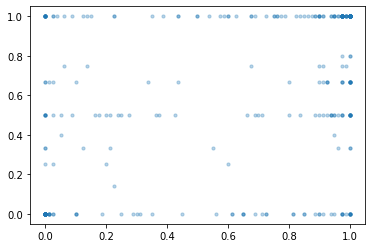

Spearman correlation: 0.6266 (p-value: 0.0000)
Pearson correlation: 0.6488 (p-value: 0.0000)


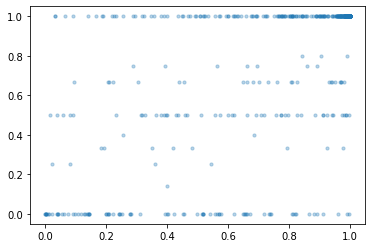

In [14]:
fields = ["species", "place"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (("species", x["attributes"]["species"]), ("place", x["attributes"]["place"]))
    value = text_probs[i][x["attributes"]["waterbird"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1])[:3])
print()

compute_correlation(
    [text_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)
compute_correlation(
    [text_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)

## Image Correlation Analysis

Epoch -1, Eval True: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.37it/s]


[((('species', 'American Crow'), ('place', 'ocean')), 0.0),
 ((('species', 'American Redstart'), ('place', 'ocean')), 0.0),
 ((('species', 'Anna Hummingbird'), ('place', 'ocean')), 0.0)]

[((('species', 'Parakeet Auklet'), ('place', 'forest broadleaf')),
  0.0008562970906496048),
 ((('species', 'Frigatebird'), ('place', 'forest broadleaf')),
  0.001073575229384005),
 ((('species', 'Scissor tailed Flycatcher'), ('place', 'ocean')),
  0.0012265233090147376)]

Spearman correlation: 0.4611 (p-value: 0.0000)
Pearson correlation: 0.4559 (p-value: 0.0000)


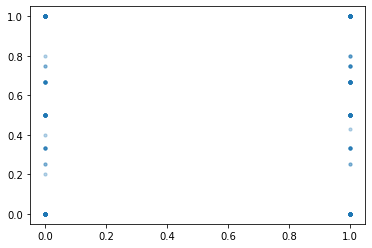

Spearman correlation: 0.5448 (p-value: 0.0000)
Pearson correlation: 0.5307 (p-value: 0.0000)


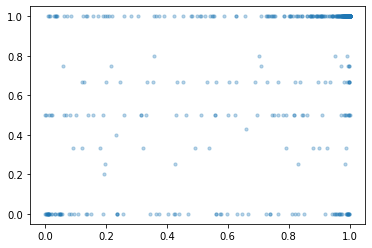

In [6]:
fields = ["species", "place"]

image_generated_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/GeneratedWaterBird/waterbird_text_data_generated_images_n=20.jsonl"
    )
]


def filter_fn(x):
    return True


image_generated_data = [x for x in image_generated_data if filter_fn(x)]


def label_fn(x):
    return x["attributes"]["waterbird"]


for item in image_generated_data:
    item["label"] = label_fn(item)

image_generated_dataset = ImageDataset(data=image_generated_data)
image_generated_dataloader = create_dataloader(
    dataset=image_generated_dataset, modality="image", transform=transform
)
image_generated_metrics = run_one_epoch(
    dataloader=image_generated_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)
image_generated_preds, image_generated_labels = (
    image_generated_metrics["preds"],
    image_generated_metrics["labels"],
)
image_generated_subgroups = subgrouping(image_generated_data, fields)
image_generated_subgroup_metrics = computing_subgroup_metrics(
    image_generated_preds, image_generated_labels, image_generated_subgroups
)
pprint(sorted(image_generated_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

image_generated_logits = image_generated_metrics["logits"]
image_generated_probs = (
    torch.softmax(torch.tensor(image_generated_logits), dim=1).numpy().tolist()
)
image_generated_subgroup_probs = defaultdict(list)
for i, x in enumerate(image_generated_data):
    key = (("species", x["attributes"]["species"]), ("place", x["attributes"]["place"]))
    value = image_generated_probs[i][x["attributes"]["waterbird"]]
    image_generated_subgroup_probs[key].append(value)
image_generated_subgroup_probs = {
    k: float(np.mean(v)) for k, v in image_generated_subgroup_probs.items()
}
pprint(sorted(image_generated_subgroup_probs.items(), key=lambda x: x[1])[:3])
print()

compute_correlation(
    [image_generated_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)  # Accuracy-Accuracy Correlation
compute_correlation(
    [image_generated_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)  # Prob-Accuracy Correlation

# Attribute-based Interpretation

In [7]:
image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/Waterbird/processed_attribute_dataset/attributes.jsonl"
    )
]


def filter_fn(x):
    return x["attributes"]["split"] == "val"


image_data = [x for x in image_data if filter_fn(x)]

attributes = {
    "place": set([x["attributes"]["place"] for x in image_data]),
    "species": set([x["attributes"]["species"] for x in image_data]),
}

## Direct influence

In [8]:
attribute_list = list(attributes["place"])

attribute_embeddings = F.normalize(
    clip_model.encode_text(clip.tokenize(attribute_list).cuda())
)
probs = torch.softmax(model(attribute_embeddings), dim=1)

attribute_scores = {
    attribute_list[i]: float(probs[i, 1]) for i in range(len(attribute_list))
}

print("If we care about waterbird (label = 1), the most similar attributes are:")
print(sorted(attribute_scores.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about waterbird (label = 1), the most similar attributes are:
[('ocean', 0.5517702102661133), ('lake natural', 0.5469737648963928), ('forest broadleaf', 0.3656281530857086), ('bamboo forest', 0.3377529978752136)]


## Aggregated Influence: Shapley Value s(a) = E_{S subset {F \ a}} [f(S, a) - f(S)]

In [9]:
place_list = list(attributes["place"])
species_list = list(attributes["species"])

attribute_shapley = {}
print(
    "If we care about waterbird (label = 1), the most influential attributes are (reported Shapley value):"
)
for place in place_list:
    prompts = [f"a photo of a {species}." for species in species_list] + [
        f"a photo of a {species} in the {place}." for species in species_list
    ]
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(species_list) :, 1] - probs[: len(species_list), 1]).mean()
    attribute_shapley[place] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about waterbird (label = 1), the most influential attributes are (reported Shapley value):
[('ocean', tensor(0.1020)),
 ('lake natural', tensor(0.0381)),
 ('forest broadleaf', tensor(-0.0877)),
 ('bamboo forest', tensor(-0.1029))]


In [10]:
place_list = list(attributes["place"])
species_list = list(attributes["species"])

attribute_shapley = {}
print(
    "If we care about waterbird (label = 1), the most influential attributes are (reported Shapley value):"
)
for species in species_list:
    prompts = [f"a photo of the {place}." for place in place_list] + [
        f"a photo of a {species} in the {place}." for place in place_list
    ]
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(place_list) :, 1] - probs[: len(place_list), 1]).mean()
    attribute_shapley[species] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about waterbird (label = 1), the most influential attributes are (reported Shapley value):
[('Glaucous winged Gull', tensor(0.1992)),
 ('Sooty Albatross', tensor(0.1895)),
 ('Caspian Tern', tensor(0.1849)),
 ('Black footed Albatross', tensor(0.1793)),
 ('California Gull', tensor(0.1644)),
 ('Laysan Albatross', tensor(0.1617)),
 ('Ring billed Gull', tensor(0.1616)),
 ('Slaty backed Gull', tensor(0.1560)),
 ('Western Grebe', tensor(0.1548)),
 ('Herring Gull', tensor(0.1537))]


# Rectifying by Continue Learning

In [12]:
text_data = [
    {
        "text": prompt(f"{x['species']} in the {x['place']}"),
        "label": species_to_label[x["species"]],
        "attributes": {
            "waterbird": species_to_label[x["species"]],
            "waterplace": places_to_label[x["place"]],
            "species": x["species"],
            "place": x["place"],
        },
    }
    for x in attributes_combinations
    for prompt in openai_imagenet_template
]
print(len(text_data))
text_data = [
    item
    for item in text_data
    if (item["attributes"]["waterbird"] == 1 and item["attributes"]["waterplace"] == 0)
    or (item["attributes"]["waterbird"] == 0 and item["attributes"]["waterplace"] == 1)
]
print(len(text_data))

text_dataset = TextDataset(data=text_data)
text_dataloader = create_dataloader(dataset=text_dataset, modality="text")
text_metrics = run_one_epoch(
    dataloader=text_dataloader,
    model=model,
    clip_model=clip_model,
    modality="text",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

64000
32000


Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.61it/s]


In [14]:
from torch.utils.data import TensorDataset, DataLoader

text_features = text_metrics["features"]
text_labels = text_metrics["labels"]
text_dataset = TensorDataset(torch.tensor(text_features), torch.tensor(text_labels))
text_dataloader = DataLoader(text_dataset, batch_size=32, shuffle=True)

fields = ["waterbird", "waterplace"]

In [18]:
model = Linear(512, 2).cuda()
state_dict = torch.load(LINEAR_MODEL)
model.load_state_dict(state_dict)


def train_one_epoch(dataloader, model, optimizer, device="cuda"):
    model.train()
    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


opimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(10):
    train_one_epoch(text_dataloader, model, opimizer)

    image_metrics = run_one_epoch(
        dataloader=image_dataloader,
        model=model,
        clip_model=clip_model,
        modality="image",
        opt=None,
        epoch_idx=-1,
        eval=True,
        verbose=True,
    )

    print(f"Epoch {epoch}")
    image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
    image_subgroups = subgrouping(image_data, fields)
    image_subgroup_metrics = computing_subgroup_metrics(
        image_preds, image_labels, image_subgroups
    )
    pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1]))
    print(np.mean(list(image_subgroup_metrics.values())))
    print()

Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.99it/s]


Epoch 0
[((('waterbird', 1), ('waterplace', 0)), 0.5037593984962406),
 ((('waterbird', 1), ('waterplace', 1)), 0.8947368421052632),
 ((('waterbird', 0), ('waterplace', 1)), 0.9141630901287554),
 ((('waterbird', 0), ('waterplace', 0)), 0.9957173447537473)]
0.8270941688710016



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.11it/s]


Epoch 1
[((('waterbird', 1), ('waterplace', 0)), 0.556390977443609),
 ((('waterbird', 1), ('waterplace', 1)), 0.8270676691729323),
 ((('waterbird', 0), ('waterplace', 1)), 0.9699570815450643),
 ((('waterbird', 0), ('waterplace', 0)), 0.9892933618843683)]
0.8356772725114935



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.27it/s]


Epoch 2
[((('waterbird', 1), ('waterplace', 0)), 0.556390977443609),
 ((('waterbird', 1), ('waterplace', 1)), 0.6917293233082706),
 ((('waterbird', 0), ('waterplace', 1)), 0.9828326180257511),
 ((('waterbird', 0), ('waterplace', 0)), 0.987152034261242)]
0.8045262382597183



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.20it/s]


Epoch 3
[((('waterbird', 1), ('waterplace', 0)), 0.5639097744360902),
 ((('waterbird', 1), ('waterplace', 1)), 0.5864661654135338),
 ((('waterbird', 0), ('waterplace', 0)), 0.9828693790149893),
 ((('waterbird', 0), ('waterplace', 1)), 0.9849785407725322)]
0.7795559649092864



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 16.88it/s]


Epoch 4
[((('waterbird', 1), ('waterplace', 1)), 0.5037593984962406),
 ((('waterbird', 1), ('waterplace', 0)), 0.5789473684210527),
 ((('waterbird', 0), ('waterplace', 0)), 0.9785867237687366),
 ((('waterbird', 0), ('waterplace', 1)), 0.9892703862660944)]
0.762640969238031



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 16.08it/s]


Epoch 5
[((('waterbird', 1), ('waterplace', 1)), 0.42105263157894735),
 ((('waterbird', 1), ('waterplace', 0)), 0.5789473684210527),
 ((('waterbird', 0), ('waterplace', 0)), 0.9528907922912205),
 ((('waterbird', 0), ('waterplace', 1)), 0.9914163090128756)]
0.736076775326024



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.99it/s]


Epoch 6
[((('waterbird', 1), ('waterplace', 1)), 0.3383458646616541),
 ((('waterbird', 1), ('waterplace', 0)), 0.5789473684210527),
 ((('waterbird', 0), ('waterplace', 0)), 0.9507494646680942),
 ((('waterbird', 0), ('waterplace', 1)), 0.9935622317596566)]
0.7154012323776144



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.31it/s]


Epoch 7
[((('waterbird', 1), ('waterplace', 1)), 0.3383458646616541),
 ((('waterbird', 1), ('waterplace', 0)), 0.5789473684210527),
 ((('waterbird', 0), ('waterplace', 0)), 0.9507494646680942),
 ((('waterbird', 0), ('waterplace', 1)), 0.9935622317596566)]
0.7154012323776144



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.08it/s]


Epoch 8
[((('waterbird', 1), ('waterplace', 1)), 0.3157894736842105),
 ((('waterbird', 1), ('waterplace', 0)), 0.5939849624060151),
 ((('waterbird', 0), ('waterplace', 0)), 0.9400428265524625),
 ((('waterbird', 0), ('waterplace', 1)), 0.9935622317596566)]
0.7108448736005862



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.42it/s]

Epoch 9
[((('waterbird', 1), ('waterplace', 1)), 0.2857142857142857),
 ((('waterbird', 1), ('waterplace', 0)), 0.6090225563909775),
 ((('waterbird', 0), ('waterplace', 0)), 0.9229122055674518),
 ((('waterbird', 0), ('waterplace', 1)), 0.9935622317596566)]
0.7028028198580929



In [20]:
model = Linear(512, 2).cuda()
opimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    train_one_epoch(text_dataloader, model, opimizer)

    image_metrics = run_one_epoch(
        dataloader=image_dataloader,
        model=model,
        clip_model=clip_model,
        modality="image",
        opt=None,
        epoch_idx=-1,
        eval=True,
        verbose=True,
    )

    print(f"Epoch {epoch}")
    image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
    image_subgroups = subgrouping(image_data, fields)
    image_subgroup_metrics = computing_subgroup_metrics(
        image_preds, image_labels, image_subgroups
    )
    pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1]))
    print(np.mean(list(image_subgroup_metrics.values())))
    print()

Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.29it/s]


Epoch 0
[((('waterbird', 1), ('waterplace', 1)), 0.045112781954887216),
 ((('waterbird', 0), ('waterplace', 0)), 0.6531049250535332),
 ((('waterbird', 1), ('waterplace', 0)), 0.706766917293233),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.6001731947020228



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.14it/s]


Epoch 1
[((('waterbird', 1), ('waterplace', 1)), 0.045112781954887216),
 ((('waterbird', 0), ('waterplace', 0)), 0.582441113490364),
 ((('waterbird', 1), ('waterplace', 0)), 0.7443609022556391),
 ((('waterbird', 0), ('waterplace', 1)), 0.9978540772532188)]
0.5924422187385272



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.91it/s]


Epoch 2
[((('waterbird', 1), ('waterplace', 1)), 0.045112781954887216),
 ((('waterbird', 0), ('waterplace', 0)), 0.5353319057815846),
 ((('waterbird', 1), ('waterplace', 0)), 0.7744360902255639),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.5876472331171184



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.67it/s]


Epoch 3
[((('waterbird', 1), ('waterplace', 1)), 0.045112781954887216),
 ((('waterbird', 0), ('waterplace', 0)), 0.5203426124197003),
 ((('waterbird', 1), ('waterplace', 0)), 0.7669172932330827),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.5820202105285269



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 19.27it/s]


Epoch 4
[((('waterbird', 1), ('waterplace', 1)), 0.045112781954887216),
 ((('waterbird', 0), ('waterplace', 0)), 0.5053533190578159),
 ((('waterbird', 1), ('waterplace', 0)), 0.7744360902255639),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.5801525864361762



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.27it/s]


Epoch 5
[((('waterbird', 1), ('waterplace', 1)), 0.03759398496240601),
 ((('waterbird', 0), ('waterplace', 0)), 0.4925053533190578),
 ((('waterbird', 1), ('waterplace', 0)), 0.7669172932330827),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.5731811965052461



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 16.88it/s]


Epoch 6
[((('waterbird', 1), ('waterplace', 1)), 0.03007518796992481),
 ((('waterbird', 0), ('waterplace', 0)), 0.4925053533190578),
 ((('waterbird', 1), ('waterplace', 0)), 0.7593984962406015),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.5694217980090055



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.50it/s]


Epoch 7
[((('waterbird', 1), ('waterplace', 1)), 0.03007518796992481),
 ((('waterbird', 0), ('waterplace', 0)), 0.4796573875802998),
 ((('waterbird', 1), ('waterplace', 0)), 0.7744360902255639),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.5699692050705565



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.18it/s]


Epoch 8
[((('waterbird', 1), ('waterplace', 1)), 0.03007518796992481),
 ((('waterbird', 0), ('waterplace', 0)), 0.47751605995717344),
 ((('waterbird', 1), ('waterplace', 0)), 0.7744360902255639),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.569433873164775



Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.87it/s]

Epoch 9
[((('waterbird', 1), ('waterplace', 1)), 0.03007518796992481),
 ((('waterbird', 0), ('waterplace', 0)), 0.4753747323340471),
 ((('waterbird', 1), ('waterplace', 0)), 0.7518796992481203),
 ((('waterbird', 0), ('waterplace', 1)), 0.9957081545064378)]
0.5632594435146325

